In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [3]:
# Load the crop mapping dwr data 
cm = gp.read_file("../shape/Crop__Mapping_2014.shp")

# Load cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# load canals shapefile 
canals = gp.read_file("../shape/Canals_and_Aqueducts_local.shp")
canals = gp.sjoin(canals, cvsa, op = "within")

# Shapefiles
hu4 = gp.read_file("../shape/HU4_merged.shp")

# swp = gp.read_file("../shape/SWP_Canals.shp")
# swp = gp.sjoin(swp, ca, op = "intersects")

# Read stream reaches from c2vsim shapefile 
reaches = gp.read_file("../c2vsim/C2VSimFG_StreamReaches.shp").dropna()
reaches = reaches.to_crs({'init': 'epsg:4326'})

# read rivers
rivers = gp.read_file("../shape/MajorRivers.shp")
rivers = gp.sjoin(rivers, hu4, op = "intersects")

# # irrigated
# irrigated = gp.read_file("../shape/irrigated.shp")
# non_irrigated = gp.read_file("../shape/non_irrigated.shp")

# SSJT
s = gp.read_file("../Shape/1802_4.shp")
sj = gp.read_file("../Shape/1804_4.shp")
t = gp.read_file("../Shape/1803_4.shp")

# grace footprint
grace_sa = gp.read_file("../shape/argus_grace.shp")

casgem = gp.read_file("../shape/casgem_wells.shp")
casgem = gp.sjoin(casgem,cvsa, op ='within')

/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [4]:
# Bar plot of of acreage by crop type in 2014
out = {}

for i in cm.DWR_Standa.unique():
    acreage = cm[cm.DWR_Standa == i]['Acres'].sum()
    out[i] = acreage*0.00404686 # acres to sq km

In [5]:
total = np.array(list(out.values())).sum()

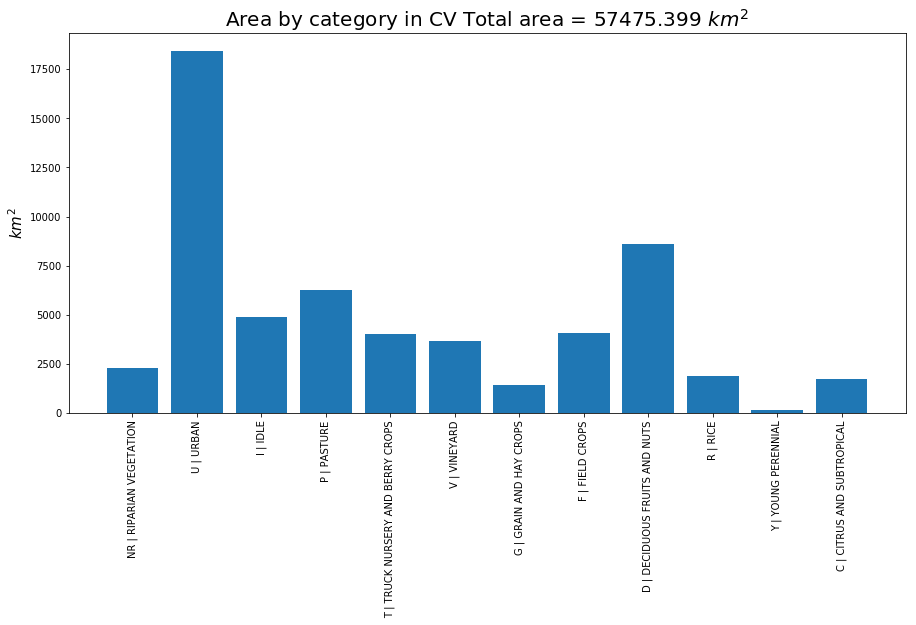

In [6]:
plt.figure(figsize=(15,7))
plt.bar(range(len(out)), out.values(), align='center')
plt.title("Area by category in CV Total area = {} $km^2$".format(str(round(total,3))), size = 20)
plt.xticks(range(len(out)), list(out.keys()),rotation='vertical')
plt.ylabel("$km^2$", size = 15)
plt.show()

In [7]:
irr_dfs = []

for i in list(cm.DWR_Standa.unique())[4:6]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[8:]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)

T | TRUCK NURSERY AND BERRY CROPS
V | VINEYARD
D | DECIDUOUS FRUITS AND NUTS
R | RICE
Y | YOUNG PERENNIAL
C | CITRUS AND SUBTROPICAL


In [8]:
non_irr_dfs = []

for i in list(cm.DWR_Standa.unique())[:1]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[6:8]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[2:4]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)

NR | RIPARIAN VEGETATION
G | GRAIN AND HAY CROPS
F | FIELD CROPS
I | IDLE
P | PASTURE


No handles with labels found to put in legend.


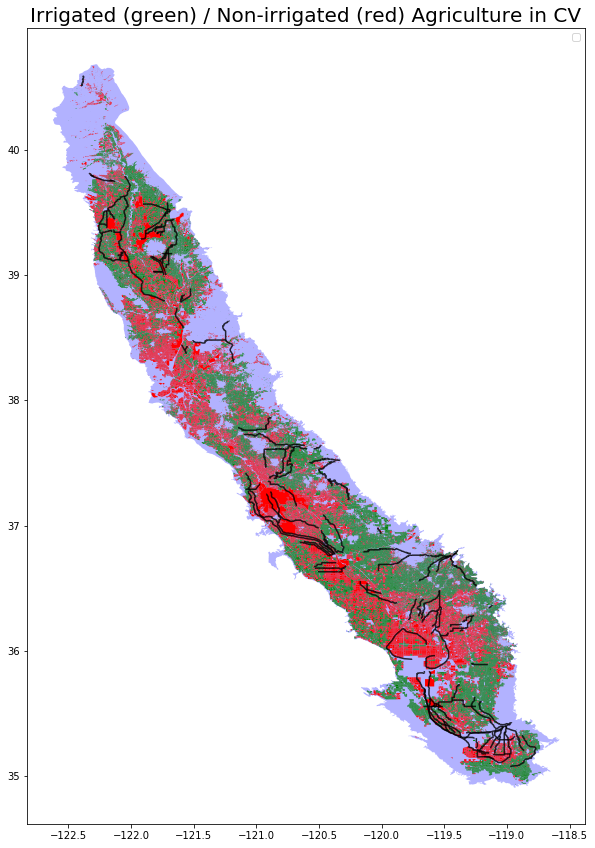

In [9]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 1, 1)
cvsa.plot(ax=ax, color = "blue", alpha = 0.3)
canals.plot(ax = ax, color = "black", alpha = 0.8)

for i in range(len(irr_dfs)):
    irr_dfs[i].plot(ax=ax, color = "green", label = "irrigated")
    
for i in range(len(non_irr_dfs)):
    non_irr_dfs[i].plot(ax=ax, color = "red", label = "non irrigated")

ax.set_title("Irrigated (green) / Non-irrigated (red) Agriculture in CV", size = 20)

plt.legend()
plt.show()

In [10]:
# Now Convert the irrigated acreage to earth engine multipoly and query the ET data 

In [11]:
irrigated = pd.concat(irr_dfs)
non_irrigated = pd.concat(non_irr_dfs)

In [ ]:
irrigated.to_file("../shape/irrigated.shp")
non_irrigated.to_file("../shape/non_irrigated.shp")